# Recommender ChatBot: Build items and interactions data

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os

BASE_PATH    = '../..'
LIB_PATH     = f'{BASE_PATH}/lib'
API_PATH     = f'{BASE_PATH}/chat-bot-api'
DATASET_PATH = f'{BASE_PATH}/datasets'
ITEMS_PATH   = f'{DATASET_PATH}/chatbot-api-movies.json'


os.environ['TMP_PATH']               = f'{BASE_PATH}/tmp'
os.environ['DATASET_PATH']           = f'{BASE_PATH}/datasets'
os.environ['WEIGHTS_PATH']           = f'{BASE_PATH}/weights'
os.environ['METRICS_PATH']           = f'{BASE_PATH}/metrics'
os.environ['MONGODB_URL']            = 'mongodb://0.0.0.0:27017'
os.environ['MONGODB_DATABASE']       = 'chatbot'
os.environ['CHROMA_HOST']            = '0.0.0.0'
os.environ['CHROMA_PORT']            = '9090'
os.environ['TOKENIZERS_PARALLELISM'] = 'false'

In [3]:
import sys
sys.path.append(LIB_PATH)
sys.path.append(API_PATH)

import pandas as pd

import util as ut

import torch
import data as dt
import data.dataset as ds

import os

from client import RecChatBotV1ApiClient

from services import ItemSimQuery

from app_context import AppContext

import pytorch_common.util as pu
from datetime import datetime

from rest import TMDBApiClient

import logging
from dataclasses import dataclass
from abc import ABC, abstractmethod
from IPython.core.display import HTML

<Figure size 640x480 with 0 Axes>

# Setup

In [4]:
pu.LoggerBuilder().on_console().build()

<RootLogger root (INFO)>

# Common Functions and Classes

In [5]:
def cos_sim(a, b, k=1):
    from strsimpy import Cosine
    sim = Cosine(k=k)
    return 1 - sim.distance(a, b)

In [6]:
def is_empty(value):
    if value is None: return True
    
    if type(value) == str and len(value) == 0: return True

    if type(value) == list:
        if len(value) == 0: return True
        if len([True for v in value if is_empty(v)]) == len(value): return True

    return False

In [7]:
def items_to_df(models):
    return pd.DataFrame([
        {
            'id'          : model.id,
            'title'       : model.title,
            'release'     : model.release,
            'genres'      : model.genres,
            'rating'      : model.rating,
            'poster'      : model.poster
        }
        for model in models
    ])


def ints_to_df(models):
    return pd.DataFrame([
        {
            'item_id' : model.user_id,
            'user_id' : model.item_id,
            'rating'  : model.rating
        }
        for model in models
    ])

In [8]:
async def append_popularity_score(items, interactions):
    from sklearn.preprocessing import MinMaxScaler

    item_votes = interactions \
        .groupby(['item_id'])['user_id'] \
        .size() \
        .reset_index(name='votes') \
        .rename(columns={'item_id': 'id'})

    
    item_votes['id'] = item_votes['id'].astype(str)

    items = item_votes.merge(items, on='id')
    
    items['votes_norm']       = items['votes'] / items['votes'].max()
    items['popularity_score'] = items['rating'] * items['votes_norm']
    items = items.drop(['votes_norm'], axis=1)

    return items.sort_values(
        by        = ['popularity_score'],
        ascending = False
    )

In [9]:
def to_image_html(path, width=300, alt='Not Found Image'): return F'<img src="{path}" width="{width}" alt={alt} >'

def show(df): display(HTML(df.to_html(escape=False)))

In [10]:
async def search_items_by_content(
    interactions,
    content,
    min_release      = None,
    min_rating       = None,
    order_popularity = True,
    limit            = 10_000
):
    items, _ = await ctx.item_service.find_similars_by(
        ItemSimQuery() \
            .contains(content) \
            .rating_gte(min_rating) \
            .release_gte(min_release) \
            .limit_eq(limit)
    )
    
    items = items_to_df(items)
                
    if order_popularity:
        items = await append_popularity_score(items, interactions)

    items['poster'] = items['poster'].apply(to_image_html)
    
    return items.reset_index()

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt


def plot_max_user_interactions_bins(df, figsize=(10, 8)):
    plt.figure(figsize=figsize)
    sns.barplot(x='n_interactions_bin', y='n_users', data=df)
    plt.title('Max user interactions by range')
    plt.xlabel('Max user interactions')
    plt.ylabel('Users count')
    plt.xticks(rotation=45)
    plt.show()

In [12]:
@dataclass(frozen=True)
class MovieDataSeeker:
    data                   : pd.DataFrame
    min_title_sim          : int          = 0.98
    min_original_title_sim : int          = 0.98

    
    def search_many_by(self, title_by_id, fields=[]):
        movies = {}
        with dt.progress_bar(len(title_by_id), title='Fetching many movies from TMDB') as pb:
                
            for id, title in title_by_id.items():
                movie = self.search_by(id, title, fields)
                if movie:
                    movies[id] = movie
                pb.update()

        return movies


    def search_by(self, id, title, fields=[]):
        movie_data = {}
        movies = self.data[id]
        if len(movies) > 0:
            for movie in movies:
                title_sim          = cos_sim(title, movie['title'])
                original_title_sim = cos_sim(title, movie['original_title'])

                title_eq = movie['title'].strip().lower() == title.strip().lower() or movie['original_title'].strip().lower() == title.strip().lower()
                
                title_match = title_sim > self.min_title_sim or original_title_sim > self.min_title_sim

                if title_eq or title_match:
                    logging.debug(f'title sim: {title_sim}, original title sim: {original_title_sim}')

                    for field in fields:
                        value = movie[field]
                        if not is_empty(value):
                            movie_data['id'] = id

                            if type(movie[field]) == list:
                                movie_data[field] = [str(v).lower() for v in movie[field]] 
                            else:
                                movie_data[field] = movie[field]
                            
                            movie_data['title_sim']          = title_sim
                            movie_data['original_title_sim'] = original_title_sim


        return movie_data

In [13]:
def resolve_missing_data(movies, row, column, field, missing_codition):
    movie_id = row['movie_id']

    if movie_id not in movies:
        return row[column]

    if not missing_codition(row[column]):
        return row[column]

    if int(movie_id) not in data:
        return row[column]
    
    movie = movies[int(movie_id)]

    if movie is None:
        return row[column]

    if field not in movie:
        return row[column]

    return movie[field]

# Build datasets

## Create and refine Items dataset

**Step 1**: Load raw dataset.

In [14]:
def to_tensor(obs, device, columns): 
    data = obs[columns]
    if type(data) == pd.DataFrame:
        data = data.values
    return torch.tensor(data).to(device)

features_fn = lambda obs, device: to_tensor(obs, device, ['user_seq', 'movie_seq'])
target_fn   = lambda obs, device: to_tensor(obs, device, ['user_movie_rating'])

In [15]:
dataset = ds.MovieLensTMDBDatasetFactory.from_path(
    path             = DATASET_PATH,
    transform        = features_fn,
    target_transform = target_fn,
    device           = torch.device('cpu'),
    filter_fn        = lambda df: df[(df['user_movie_rating_year'] >= 2004)]
)

**Step 2**: Build items table.

In [16]:
if not os.path.exists(ITEMS_PATH):
    items = dataset \
        .data[['movie_id', 'movie_title', 'movie_genres', 'movie_overview', 'movie_release_year', 'movie_imdb_id', 'user_movie_rating']]

    item_mean_rating = items.groupby(['movie_id'])['user_movie_rating'].mean().reset_index()
    items = items.drop_duplicates(subset=['movie_id']).drop(columns=['user_movie_rating'])
    items[items['movie_title'] == 'Paths of Glory']
    items = items.merge(item_mean_rating, on='movie_id')
    items

**Step 3**: Populate items table posters.

In [17]:
if not os.path.exists(ITEMS_PATH):
    from rest import TMDBApiClient
    import logging

    client = TMDBApiClient()

    with dt.progress_bar(items.shape[0], title='Processing') as pb:
        def resolve_url(title):
            return (title, client.find_first_poster_by(title))

        params = [[row['movie_title']] for _, row in items.iterrows()]

        poster_by_id = ut.ParallelExecutor()(
            resolve_url,
            params = params,
            fallback_result = None
        )

        poster_by_id = {item[0]: item[1] for item in poster_by_id}

**Step 4**: Save items table with post urls. (Step 3 process takes a long time).

In [18]:
if not os.path.exists(ITEMS_PATH):
    items['poster'] = items['movie_title'].apply(lambda title: poster_by_id[title])
    ut.save_df(items, f'{DATASET_PATH}/chatbot-api-movies.json')

**Step 5**: Reload items table. 

In [19]:
items = ut.load_df(f'{DATASET_PATH}/chatbot-api-movies.json')

In [20]:
pd.set_option('display.max_colwidth', None)
items[['movie_title', 'poster']].head()

,movie_title,poster
0,Toy Story,http://image.tmdb.org/t/p/w500/uXDfjJbdP4ijW5hWSBrPrlKpxab.jpg
1,Clueless,http://image.tmdb.org/t/p/w500/8AwVTcgpTnmeOs4TdTWqcFDXEsA.jpg
2,While You Were Sleeping,http://image.tmdb.org/t/p/w500/qNGO3ETcNwlWqK2kNRpbJSJRlos.jpg
3,Forrest Gump,http://image.tmdb.org/t/p/w500/arw2vcBveWOVZr6pxd9XTd1TdQa.jpg
4,Pretty Woman,http://image.tmdb.org/t/p/w500/hVHUfT801LQATGd26VPzhorIYza.jpg


### Populate missing items data using a TMDB API client.

**Step 1**: Pull movies data from TMDB API.

In [21]:
item_title_by_id = ut.to_dict(
    items,
    key   = 'movie_id',
    value = 'movie_title'
)

item_title_by_id = {id: title.strip() for id, title in item_title_by_id.items()}

fields = [
     'title',
     'original_title', 
     'poster_url',
     'overview', 
     'genres',
     'release_date'
]

    
if not os.path.exists(f'{DATASET_PATH}/tmdb-api-raw-data.dt'):
    client = TMDBApiClient()

    data = client.parallel_find_many_movies_by(
        item_title_by_id,
        fields = fields
    )
    ut.Picket.save(f'{DATASET_PATH}/tmdb-api-raw-data.dt', data)
else:
    data = ut.Picket.load(f'{DATASET_PATH}/tmdb-api-raw-data.dt')

In [23]:
movie_seeker = MovieDataSeeker(data)

movies = movie_seeker.search_many_by(
    item_title_by_id,
    fields = fields
)

Fetching many movies from TMDB:   0%|          | 0/18608 [00:00<?, ?it/s]

**Step 2**: Save TMDB movies data (Step 1 process take long time).

In [24]:
ut.Picket.save(f'{DATASET_PATH}/movies.dt', movies)

In [25]:
movies = ut.Picket.load(f'{DATASET_PATH}/movies.dt')

In [26]:
len(movies), items.shape

(16149, (18608, 8))

**Step 3**: Populate items with missing overview from movies data.

In [27]:
incomplete_items = items[((items['movie_overview'] == 'No overview found.') | (items['movie_overview'] == ''))]
incomplete_items.shape

(127, 8)

In [28]:
overview_missing_codition = lambda value: is_empty(value) or value == 'No overview found.'

items['movie_overview'] = items.apply(lambda row: resolve_missing_data(movies, row, column='movie_overview', field='overview', missing_codition=overview_missing_codition), axis=1) 

In [29]:
incomplete_items = items[((items['movie_overview'] == 'No overview found.') | (items['movie_overview'] == ''))]
incomplete_items.shape

(31, 8)

**Step 4**: Populate items withmissing genres from movies data.

In [30]:
incomplete_items = items[items['movie_genres'].apply(lambda x: '(no genres listed)' in x)]
incomplete_items.shape

(286, 8)

In [31]:
genres_missing_codition = lambda value: len(value) == 1 and value[0].strip() == '(no genres listed)'

items['movie_genres'] = items.apply(lambda row: resolve_missing_data(movies, row, column='movie_genres', field='genres', missing_codition=genres_missing_codition), axis=1) 

In [32]:
incomplete_items = items[items['movie_genres'].apply(lambda x: '(no genres listed)' in x)]
incomplete_items.shape

(41, 8)

**Step 5**: Populate items with only one genre from movies data.

In [33]:
incomplete_items = items[items['movie_genres'].apply(lambda x: len(x) == 1)]
incomplete_items.shape

(6581, 8)

In [34]:
min_genres_missing_codition = lambda value: len(value) == 1

items['movie_genres'] = items.apply(lambda row: resolve_missing_data(movies, row, column='movie_genres', field='genres', missing_codition=min_genres_missing_codition), axis=1) 

In [35]:
incomplete_items = items[items['movie_genres'].apply(lambda x: len(x) == 1)]
incomplete_items.shape

(4050, 8)

In [38]:
ut.save_df(items, f'{DATASET_PATH}/pre-processed-movies.json')

## Create interactions dev and test sets

**Step 1**: Select interacctions set columns.

In [116]:
interactions = dataset \
    .data[['user_id', 'movie_id', 'user_movie_rating', 'user_movie_rating_timestamp']] \
    .rename(columns={
        'user_movie_rating'           : 'rating',
        'movie_id'                    : 'item_id',
        'user_movie_rating_timestamp' : 'timestamp'
    })

interactions.head()

,user_id,item_id,rating,timestamp
0,100538,1,4,2019-01-01 21:11:09
496,100538,39,3,2019-01-03 11:58:44
8785,100538,339,3,2019-01-04 08:18:24
9194,100538,356,4,2019-01-03 10:37:28
14189,100538,597,4,2019-01-03 11:55:57


**Step 2**: Typify user with interactions count ranges

In [117]:
user_interactions_count = interactions.groupby(['user_id']).size().reset_index(name='n_interactions')
# user_interactions_count

In [121]:
user_interaction_bins = user_interactions_count.pipe(
    ut.bins_column,
    'n_interactions',
    [20, 30, 40, 50, 60, 70, 80, 90, 100, 200]
)
user_interaction_bins.head()

,user_id,n_interactions,n_interactions_bin
0,3,1,0-19
1,4,6,0-19
2,19,1,0-19
3,43,1,0-19
4,68,1,0-19


**Step 3**: Remove users with less than 20 interactions.

In [123]:
user_interaction_bins = user_interaction_bins[user_interaction_bins['n_interactions_bin'] != '0-19']
user_interaction_bins.head()

,user_id,n_interactions,n_interactions_bin
6,91,82,80-89
26,264,37,30-39
56,610,39,30-39
59,647,60,50-59
61,653,132,100-199


**Step 4**: Count users by max interactions ranges

In [66]:
max_user_interactions_by_bin = user_interaction_bins \
    .groupby(['n_interactions_bin']) \
    ['user_id'] \
    .count() \
    .reset_index(name='user_id') \
    .rename(columns={'user_id': 'n_users'})
# max_user_interactions_by_bin

In [67]:
# max_user_interactions_by_bin['user_id'].sum()

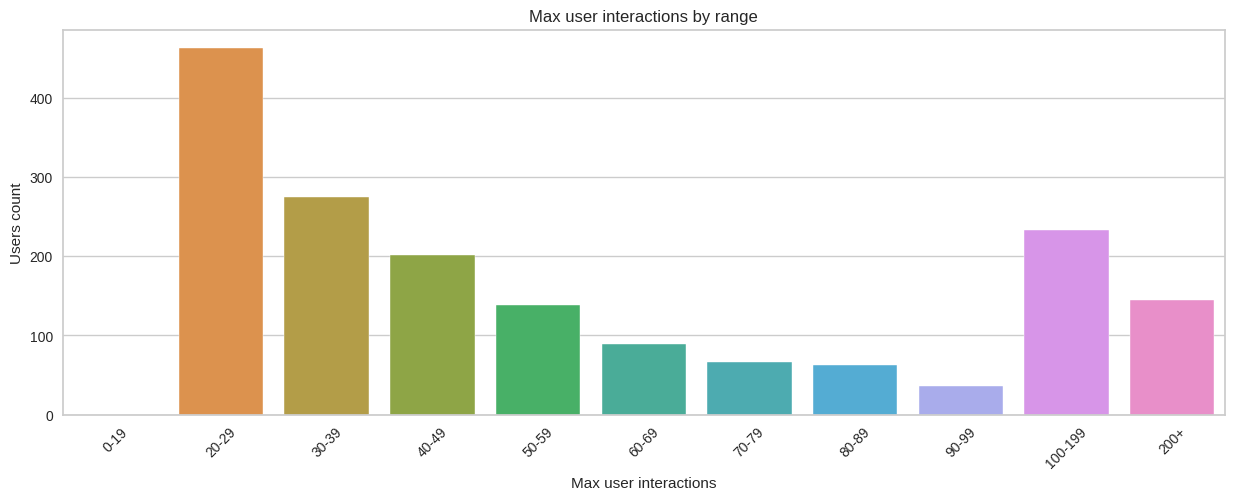

In [68]:
plot_max_user_interactions_bins(max_user_interactions_by_bin, figsize=(15, 5))

**Observations**

* We are not intersted into usr with more that 200 interactions. We consider them outlier users.
*  Same story with users les than 20 interations. This users get wrong results with collaborative fiilterging models. They are not suitable to buils an interactions test set.

**Step 5**: Remove ranges with outliers users.

In [125]:
selected_bins = max_user_interactions_by_bin['n_interactions_bin'].values[1:-1].tolist()
selected_bins

['20-29',
 '30-39',
 '40-49',
 '50-59',
 '60-69',
 '70-79',
 '80-89',
 '90-99',
 '100-199']

**Step 5**: Select 15 users from each group to build a interactions test set that represent the average user behavior.

In [70]:
groups = user_interaction_bins[['n_interactions_bin', 'user_id']] \
    .drop_duplicates() \
    .groupby('n_interactions_bin')

In [71]:
import random 

users_sample_size = 15
test_set_users = []

for curr_bin in selected_bins:
    group_df = groups.get_group(curr_bin)
    user_ids = group_df['user_id'].values.tolist()
    test_set_users.extend(random.sample(user_ids, users_sample_size))
    
len(test_set_users)

150

**Step 6**: Split an save dev an d test interactions sets.

In [72]:
split_criterion = interactions['user_id'].isin(test_set_users)

interactions_dev_set  = interactions[~split_criterion]
interactions_test_set = interactions[split_criterion]

In [73]:
interactions_dev_set.shape, interactions_test_set.shape

((179918, 4), (14355, 4))

In [74]:
len(interactions_dev_set)/len(interactions), len(interactions_test_set)/len(interactions)

(0.9261091350831047, 0.0738908649168953)

In [75]:
del interactions

In [109]:
ut.save_df(interactions_dev_set,  f'{DATASET_PATH}/interactions_dev_set.json' )
ut.save_df(interactions_test_set, f'{DATASET_PATH}/interactions_test_set.json')

# Upload items and interactions to RecChatBotAPI

Finally is necessary insert items and interactions into **Recommendations Chatbot API** databases.

In [93]:
client = RecChatBotV1ApiClient()

**Step 1**: Add items to Charbot API databases

In [198]:
client.add_items(items)

2024-02-25 16:55:22,927 - INFO - Page Size: 1000
2024-02-25 16:55:32,073 - INFO - Page: 1/19, Size: 1000
2024-02-25 16:55:37,674 - INFO - Page: 2/19, Size: 1000
2024-02-25 16:55:44,024 - INFO - Page: 3/19, Size: 1000
2024-02-25 16:55:49,590 - INFO - Page: 4/19, Size: 1000
2024-02-25 16:55:55,104 - INFO - Page: 5/19, Size: 1000
2024-02-25 16:56:00,822 - INFO - Page: 6/19, Size: 1000
2024-02-25 16:56:06,506 - INFO - Page: 7/19, Size: 1000
2024-02-25 16:56:13,517 - INFO - Page: 8/19, Size: 1000
2024-02-25 16:56:19,246 - INFO - Page: 9/19, Size: 1000
2024-02-25 16:56:25,004 - INFO - Page: 10/19, Size: 1000
2024-02-25 16:56:32,249 - INFO - Page: 11/19, Size: 1000
2024-02-25 16:56:38,229 - INFO - Page: 12/19, Size: 1000
2024-02-25 16:56:44,253 - INFO - Page: 13/19, Size: 1000
2024-02-25 16:56:51,213 - INFO - Page: 14/19, Size: 1000
2024-02-25 16:56:57,110 - INFO - Page: 15/19, Size: 1000
2024-02-25 16:57:02,816 - INFO - Page: 16/19, Size: 1000
2024-02-25 16:57:08,655 - INFO - Page: 17/19, Si

[]

In [94]:
interactions_dev_set.shape

(179918, 4)

**Step 2**: Add interactions dev set to Charbot API databases (the test set will be used to evalua chatbot API).

In [95]:
client.add_interactions(interactions_dev_set)

2024-03-16 12:48:01,690 - INFO - Page Size: 5000
2024-03-16 12:48:01,967 - INFO - Page: 1/36, Size: 5000
2024-03-16 12:48:02,234 - INFO - Page: 2/36, Size: 5000
2024-03-16 12:48:02,478 - INFO - Page: 3/36, Size: 5000
2024-03-16 12:48:02,727 - INFO - Page: 4/36, Size: 5000
2024-03-16 12:48:03,218 - INFO - Page: 5/36, Size: 5000
2024-03-16 12:48:03,508 - INFO - Page: 6/36, Size: 5000
2024-03-16 12:48:03,750 - INFO - Page: 7/36, Size: 5000
2024-03-16 12:48:04,009 - INFO - Page: 8/36, Size: 5000
2024-03-16 12:48:04,251 - INFO - Page: 9/36, Size: 5000
2024-03-16 12:48:04,493 - INFO - Page: 10/36, Size: 5000
2024-03-16 12:48:04,736 - INFO - Page: 11/36, Size: 5000
2024-03-16 12:48:04,985 - INFO - Page: 12/36, Size: 5000
2024-03-16 12:48:05,222 - INFO - Page: 13/36, Size: 5000
2024-03-16 12:48:05,463 - INFO - Page: 14/36, Size: 5000
2024-03-16 12:48:05,720 - INFO - Page: 15/36, Size: 5000
2024-03-16 12:48:06,130 - INFO - Page: 16/36, Size: 5000
2024-03-16 12:48:06,363 - INFO - Page: 17/36, Si

[]

In [96]:
api_interactions = ints_to_df(await ctx.interaction_service.find_all())
api_interactions.shape

(179918, 3)

## Fun users interactions

Create artificial users who dimulate to be fans of a particular genre or group of genres. This users improve collaborative filtering models and embeding similarity matching.

**Step 1**: Build prompts to search items by content similarity(via embeddings). 

In [97]:
searchs = [
    ('pixar animated movie for children', 200),
    ('science fiction, action', 100),
    ('war weapons', 70),
    ('iron man, x-men, spider man, bat man, flash, avengers, ant-man, hulk, guardians of the galaxy, marvel, green lantern, superman, watchmen, thor, deadpool, wonder woman, strange, justice League, captain america, logans, kick ass, John Wick', 150),
    ('sci-fi, action, future', 130),
    ('Mission Impossible, spies, bourne identity, 007', 70),
    ('comedy movies', 200),
    ('horror', 100),
    ('thiller, suspense', 150),
    ('love, romance', 150),
    ('time travel', 100),
    ('dead, zombies, post apocalyptic', 100),
    ('software', 100),
    ('hackers', 100)
]

**Step 2**: Craete fun users interactions.

In [101]:
items = await search_items_by_content(
    interactions_dev_set, 
    'hackers',
    min_rating  = 3, 
    limit       = 50,
    min_release = 1990,
    order_popularity = False
)


# show(items)

In [104]:
fun_user_interactions = []
max_user_id = interactions_dev_set['user_id'].max()

for search in searchs:    
    items = await search_items_by_content(
        interactions_dev_set, 
        search[0],
        min_rating  = 3, 
        limit       = search[1],
        min_release = 1990,
        order_popularity = False
    )    
    
    items = items.rename(columns={'id': 'item_id'})
    items['rating'] = items['item_id'].apply(lambda x: 4 if random.random() > 0.5 else 5)
    items['user_id'] = max_user_id
    items = items[['item_id', 'user_id', 'rating']]
    
    max_user_id +=1
    
    fun_user_interactions.append(items)

fun_user_interactions = pd.concat(fun_user_interactions)
fun_user_interactions['timestamp'] = datetime.now()

In [105]:
fun_user_interactions

,item_id,user_id,rating,timestamp
0,1,162521,4,2024-03-16 12:49:24.645546
1,101262,162521,4,2024-03-16 12:49:24.645546
2,105468,162521,4,2024-03-16 12:49:24.645546
3,106022,162521,5,2024-03-16 12:49:24.645546
4,106423,162521,5,2024-03-16 12:49:24.645546
...,...,...,...,...
65,8628,162534,5,2024-03-16 12:49:24.645546
66,89337,162534,5,2024-03-16 12:49:24.645546
67,92475,162534,5,2024-03-16 12:49:24.645546
68,94130,162534,4,2024-03-16 12:49:24.645546


**Step 3**: Insert fun users interactions.

In [106]:
client.add_interactions(fun_user_interactions)

2024-03-16 12:49:24,728 - INFO - Page Size: 5000
2024-03-16 12:49:24,817 - INFO - Page: 1/1, Size: 1158


[]

In [107]:
ctx = AppContext()

api_interactions = ints_to_df(await ctx.interaction_service.find_all())
api_interactions.shape

(181076, 3)